In [1]:
import pandas as pd
from pyts.image import RecurrencePlot
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels_map = ["Walk", "Run", "Stair up", "Stair down", 
              "Sit on a chair", "Sit down on a chair",
             "Stand up from a chair", "Stand on a solid surface", "Bicycle", "Stand in a lift-up", 
              "Stand in a lift-down", "Sit on car"]

In [3]:
df = pd.read_csv("all_data_transformed.csv")

In [4]:
df.head()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act,file_name
0,-32768,-700,-13076,-2119,-3471,-3687,-22024,1568,-24824,1144,...,-16400,528,8728,3323,9041,1596,141,130,1,9.csv
1,-32768,1892,-30320,604,-2370,-1312,-10072,3760,-27896,1137,...,-17208,824,3376,5452,8223,1536,100,144,1,9.csv
2,-32768,23792,-32768,488,-1102,443,-6456,12392,-30248,-464,...,-20484,3952,304,10886,7393,260,63,130,1,9.csv
3,-32768,21700,-32768,-1188,826,1082,-7256,7288,-25176,-1225,...,-21272,2880,500,11741,4437,697,165,124,1,9.csv
4,-29156,-32768,32767,514,2317,3323,-23968,-2432,11712,-2652,...,-19828,2516,3724,11877,1454,492,167,128,1,9.csv


In [5]:
df.shape[0]

2043200

In [6]:
from sklearn import preprocessing
label_name = "act"
file_name = "file_name"
features = list(df.columns)
features.remove(label_name)
features.remove(file_name)
x = df[features].values #returns a numpy array
y = df[label_name].values
file_name_val = df[file_name].values
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=features)
df[label_name] = y
df[file_name] = file_name_val

In [7]:
df.head()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act,file_name
0,-2.363223,0.545740,-2.728986,-0.345988,-0.292513,-0.410732,-1.001092,0.506787,-2.625044,0.206034,...,-0.009216,-0.170916,0.440473,0.582371,1.299102,0.515948,0.807379,0.145904,1,9.csv
1,-2.363223,0.857305,-4.626821,0.171227,-0.193961,-0.131366,0.856330,0.884963,-3.015958,0.204905,...,-0.011330,-0.115550,-0.069824,0.972258,1.182668,0.492818,-1.335467,0.803628,1,9.csv
2,-2.363223,3.489737,-4.896242,0.149194,-0.080462,0.075071,1.418281,2.374204,-3.315252,-0.053191,...,-0.019899,0.469532,-0.362730,1.967393,1.064525,0.000923,-3.269255,0.145904,1,9.csv
3,-2.363223,3.238274,-4.896242,-0.169151,0.092115,0.150235,1.293956,1.493633,-2.669836,-0.175872,...,-0.021960,0.269018,-0.344042,2.123970,0.643767,0.169386,2.061728,-0.135978,1,9.csv
4,-1.969328,-3.308910,2.316387,0.154133,0.225576,0.413839,-1.303203,-0.183316,2.024192,-0.405918,...,-0.018183,0.200933,-0.036644,2.148876,0.219165,0.090359,2.166257,0.051943,1,9.csv


In [8]:
def make_data_set(df):
    label_name = "act"
    file_name_col = "file_name"
    nrows = df.shape[0]
    nrow_split = 100
    features = list(df.columns)
    features.remove(label_name)
    features.remove(file_name_col)
    n_samples = nrows//nrow_split
    X = np.zeros((n_samples, len(features), nrow_split))
    y = np.zeros(n_samples)
    for i in range(0, n_samples):
        df_tmp = df[i*nrow_split: (i+1)*nrow_split].copy()
        X[i] = df_tmp[features].values.transpose()
        y[i] = df_tmp[label_name].tolist()[0]
    print(X.shape)
    print(y.shape)
    print(len(np.unique(y)))
    return X, y

In [9]:
def draw_acc_history(history, save=False, file_name=None):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        if not file_name:
            file_name = str(int(time.time()))
        plt.savefig("images/acc_{}.svg".format(file_name), bbox_inches='tight')
    plt.show()

In [10]:
def draw_loss_history(history, save=False, file_name=None):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        if not file_name:
            file_name = str(int(time.time()))
        plt.savefig("images/loss_{}.svg".format(file_name), bbox_inches='tight')
    plt.show()

In [11]:

import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', save=False, file_name=None):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    line = lines[len(lines) - 2]
    line = line.replace(' avg', '-avg')
    t = line.strip().split()
    classes.append(t[0])
    v = [float(x) for x in t[1: len(t) - 1]]
    support.append(int(t[-1]))
    class_names.append(t[0])
    print(v)
    plotMat.append(v)
    data = lines[2 : (len(lines) - 5)].copy()
    data.reverse()
    for line in data:
        t = [item.strip() for item in line.strip().split("      ")]
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)



    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))
    print(class_names)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    if save:
        if not file_name:
            file_name = str(int(time.time()))
        plt.savefig("images/cls_report_{}.svg".format(file_name), bbox_inches='tight')
    plt.show()


In [12]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, save=False, file_name=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if save:
        if not file_name:
            file_name = str(int(time.time()))
        plt.savefig("images/cfs_matrix_{}.svg".format(file_name), bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [13]:
def visualize_image(X_train_transform, y_train, shape_image):
    labels_map = ["Walking", "Running", "Going up", "Going down", 
              "Sitting", "Sitting down",
             "Standing up", "Standing", "Bicycling", "Up by elevator", 
              "Down by elevator", "Sitting in car"]
    fig = plt.figure(figsize=(10, 30))
    labels = list(set(y_train))
    labels.sort()
    columns = 4
    rows = len(labels)
    start_label = 0
    count = 0
    for i in range(1, columns*rows +1):
        if count % 4 == 0 and count != 0:
            start_label += 1
    #     print(start_label)
        img = X_train_transform[y_train==start_label][count%4].reshape(shape_image[0], shape_image[1])
        a = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        a.set_title(labels_map[start_label])
        count += 1
    plt.show()

# CNN with raw data

In [14]:
all_columns = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
                  'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
                  'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
                  'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
                  'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
                  'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
                  'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
                  'gyro_lt_z', 'EMG_r', 'EMG_l']
# tmp = df[all_columns].values
# tmp = tmp.reshape(-1, 100, 38)
# _, y = make_data_set(df)


In [63]:
y = y-1
print(tmp.shape)
print(y.shape)

(20432, 100, 38)
(20432,)


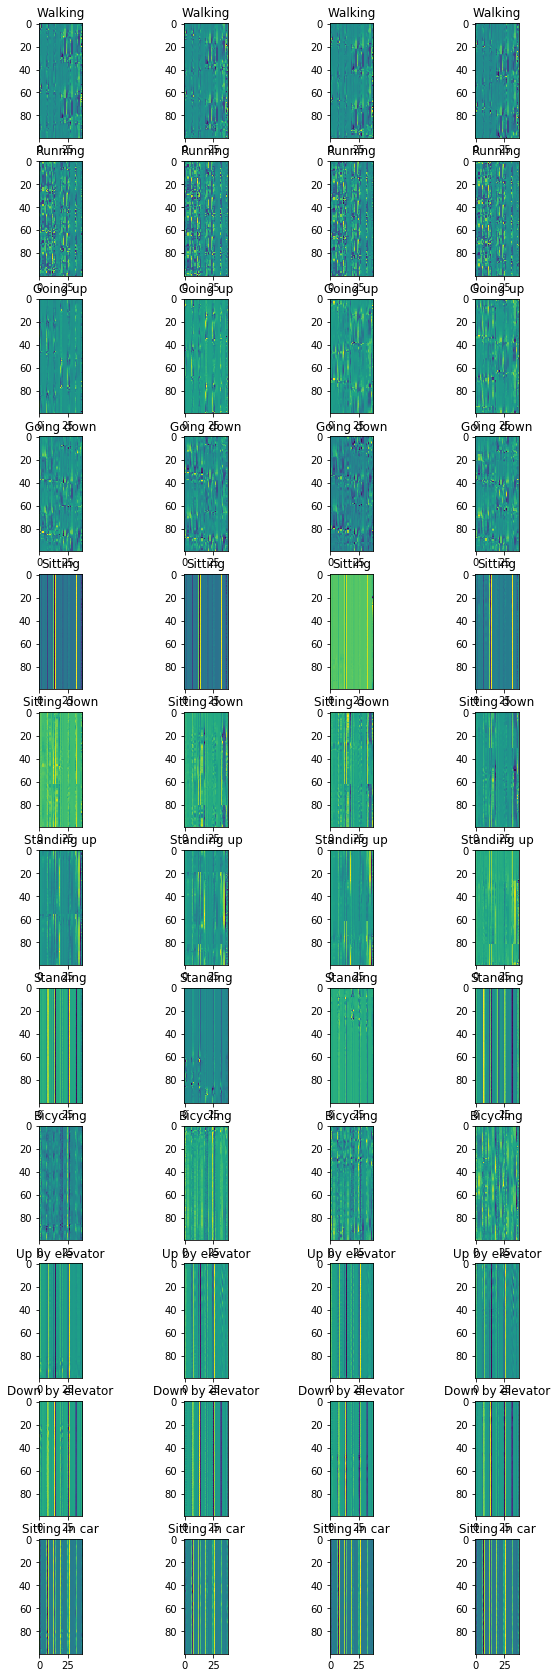

In [18]:
visualize_image(tmp, y, (100, 38))

In [15]:
file_name = [8, 10, 12]
df_train = df.loc[~df["file_name"].isin(["{}.csv".format(name) for name in file_name])].copy()
df_val = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[0:1]])].copy()
df_test = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[1:]])].copy()
_, y_train = make_data_set(df_train)
_, y_val = make_data_set(df_val)
_, y_test = make_data_set(df_test)
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

(17499, 38, 100)
(17499,)
12
(1000, 38, 100)
(1000,)
10
(1933, 38, 100)
(1933,)
10


In [16]:
X_train = df_train[all_columns].values
X_train = X_train.reshape(-1, 100, 38)
X_val = df_val[all_columns].values
X_val = X_val.reshape(-1, 100, 38)
X_test = df_test[all_columns].values
X_test = X_test.reshape(-1, 100, 38)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import time

def evaluate_model(X_train, y_train, X_test, y_test, X_val, y_val):
    verbose, epochs, batch_size = 1, 15, 64
    #	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 12
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    start = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
    # evaluate model
    print("Training time: ", time.time()-start)
    
    _, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    print("Train: ", train_accuracy)
    
    _, val_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    print("Val: ", val_accuracy)
    
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print("Test: ", accuracy)
    
    y_pred = model.predict_classes(X_test, verbose=1)
    labels = np.argmax(y_test, axis=1)
    cfs_matrix = metrics.confusion_matrix(labels, y_pred)
    print(cfs_matrix)
    # draw
    
    cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
    clfReport = str(metrics.classification_report(labels, y_pred, target_names=cls))
    print(clfReport)
    draw_acc_history(history)
    draw_loss_history(history)
    plot_classification_report(clfReport)
    plot_confusion_matrix(cfs_matrix, target_names=cls, normalize    = False)
    return accuracy


Using TensorFlow backend.


In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train.shape)
from keras.utils import to_categorical
y_train_transform = to_categorical(y_train, num_classes=12)
y_val_transform = to_categorical(y_val, num_classes=12)
y_test_transform = to_categorical(y_test, num_classes=12)

(17499, 100, 38, 1)


W0523 01:59:39.056610 139622321907456 deprecation_wrapper.py:119] From /home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0523 01:59:39.071055 139622321907456 deprecation_wrapper.py:119] From /home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0523 01:59:39.072629 139622321907456 deprecation_wrapper.py:119] From /home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0523 01:59:39.087988 139622321907456 deprecation_wrapper.py:119] From /home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.p

Train on 17499 samples, validate on 1000 samples
Epoch 1/15
17499/17499 [==============================] - 7s 419us/step - loss: 0.6119 - acc: 0.8292 - val_loss: 0.9335 - val_acc: 0.7460
Epoch 2/15
17499/17499 [==============================] - 5s 260us/step - loss: 0.2475 - acc: 0.9061 - val_loss: 0.6996 - val_acc: 0.8100
Epoch 3/15
17499/17499 [==============================] - 4s 254us/step - loss: 0.2104 - acc: 0.9156 - val_loss: 1.0297 - val_acc: 0.8130
Epoch 4/15
17499/17499 [==============================] - 5s 258us/step - loss: 0.1923 - acc: 0.9157 - val_loss: 1.0570 - val_acc: 0.8270
Epoch 5/15
17499/17499 [==============================] - 5s 270us/step - loss: 0.1788 - acc: 0.9195 - val_loss: 1.4136 - val_acc: 0.7970
Epoch 6/15
17499/17499 [==============================] - 4s 252us/step - loss: 0.1736 - acc: 0.9213 - val_loss: 1.3381 - val_acc: 0.8120
Epoch 7/15
17499/17499 [==============================] - 5s 266us/step - loss: 0.1672 - acc: 0.9225 - val_loss: 1.4559 - v

/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


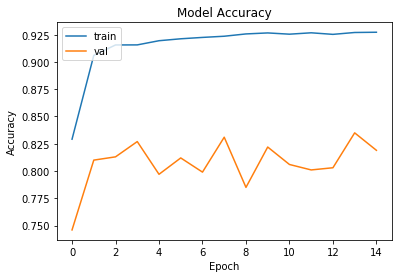

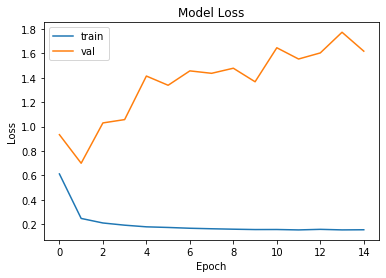

[0.9, 0.88, 0.86]
[0.0, 0.0, 0.0]
[1.0, 0.01, 0.02]
[0.0, 0.0, 0.0]
[0.69, 0.9, 0.78]
[1.0, 0.67, 0.8]
[1.0, 0.52, 0.69]
[0.95, 1.0, 0.97]
[0.98, 0.88, 0.93]
[0.88, 1.0, 0.94]
[0.98, 1.0, 0.99]
[1.0, 0.99, 0.99]
plotMat: [[0.9, 0.88, 0.86], [0.0, 0.0, 0.0], [1.0, 0.01, 0.02], [0.0, 0.0, 0.0], [0.69, 0.9, 0.78], [1.0, 0.67, 0.8], [1.0, 0.52, 0.69], [0.95, 1.0, 0.97], [0.98, 0.88, 0.93], [0.88, 1.0, 0.94], [0.98, 1.0, 0.99], [1.0, 0.99, 0.99]]
support: [1933, 54, 105, 0, 327, 21, 23, 315, 141, 154, 53, 740]
['weighted-avg', 'Stand in a lift-down', 'Stand in a lift-up', 'Bicycle', 'Stand on a solid surface', 'Stand up from a chair', 'Sit down on a chair', 'Sit on a chair', 'Stair down', 'Stair up', 'Run', 'Walk']


/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visib

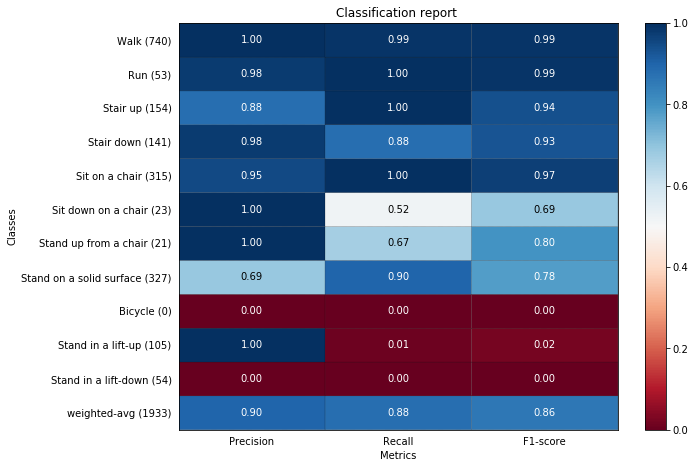

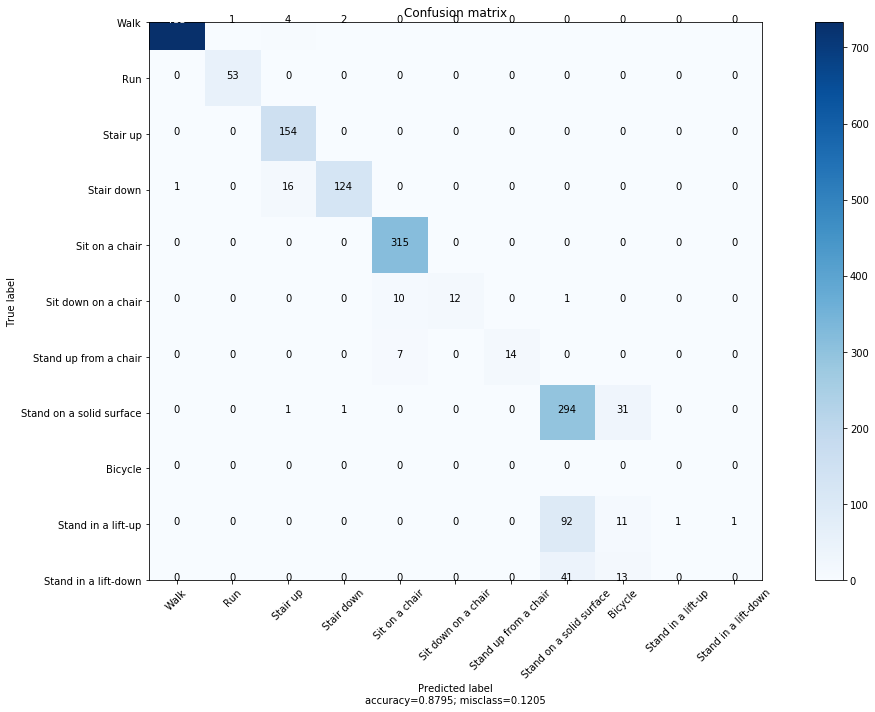

0.8794619762027935

In [19]:
evaluate_model(X_train, y_train_transform, X_test, y_test_transform, X_val, y_val_transform)

# SVM

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
# ACC: 0.90

# CNN 3D

In [20]:
file_name = [8, 10, 12]
df_train = df.loc[~df["file_name"].isin(["{}.csv".format(name) for name in file_name])].copy()
df_val = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[0:1]])].copy()
df_test = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[1:]])].copy()
_, y_train = make_data_set(df_train)
_, y_val = make_data_set(df_val)
_, y_test = make_data_set(df_test)
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1
col_3d = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
                  'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
                  'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
                  'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
                  'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
                  'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
                  'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
                  'gyro_lt_z']
X_train = df_train[col_3d].values
X_train = X_train.reshape(-1, 100, 12, 3)
X_val = df_val[col_3d].values
X_val = X_val.reshape(-1, 100, 12, 3)
X_test = df_test[col_3d].values
X_test = X_test.reshape(-1, 100, 12, 3)

(17499, 38, 100)
(17499,)
12
(1000, 38, 100)
(1000,)
10
(1933, 38, 100)
(1933,)
10


In [48]:
X_train.shape

(18499, 100, 12, 3)

In [49]:
def visualize_3d_image(X_train_transform, y_train):
    labels_map = ["Walking", "Running", "Taking stairs up", "Taking stairs down", 
              "Sitting on chair", "Sitting down on chair",
             "Standing up", "Static standing", "Bicycling", "Standing in elevator up", 
              "Standing in elevator down", "Sitting on car"]
    fig = plt.figure(figsize=(10, 30))
    labels = list(set(y_train))
    labels.sort()
    columns = 4
    rows = len(labels)
    start_label = 0
    count = 0
    for i in range(1, columns*rows +1):
        if count % 4 == 0 and count != 0:
            start_label += 1
    #     print(start_label)
        img = X_train_transform[y_train==start_label][count%4]
        print(img.shape)
        a = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        a.set_title(labels_map[start_label])
        count += 1
    plt.show()

W0512 18:23:59.260469 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.345119 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.434167 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


W0512 18:23:59.523591 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.543709 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.559915 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.575006 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.590034 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.607288 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.633782 140396

(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


W0512 18:23:59.721991 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.739426 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.776995 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.816204 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.855329 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.894665 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.910396 140396

(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


W0512 18:23:59.937375 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.950577 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.963659 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.977461 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:23:59.990612 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.003720 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.050431 140396

(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


W0512 18:24:00.150082 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.199256 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.220218 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.251653 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.271947 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.304199 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.321321 140396

(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


W0512 18:24:00.402951 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.415990 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.433259 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.464078 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.482823 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0512 18:24:00.513253 140396913280768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)
(100, 12, 3)


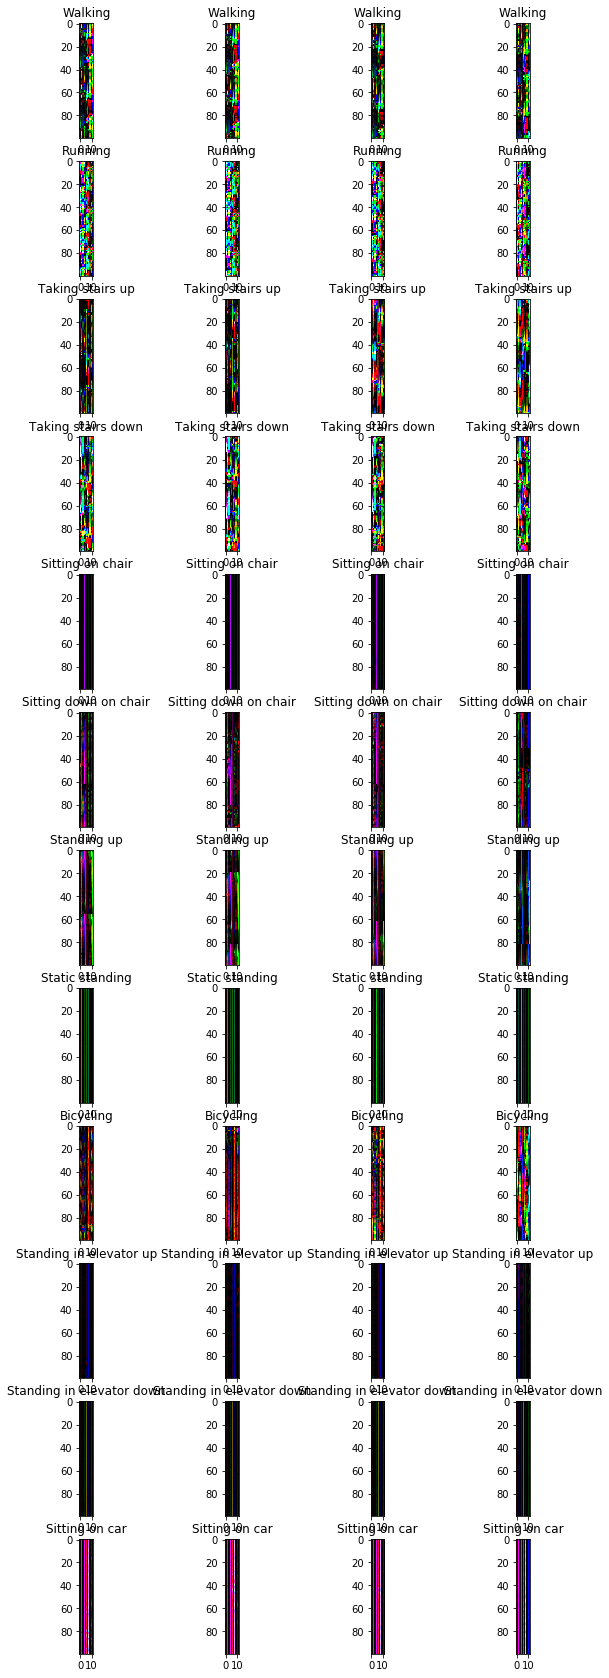

In [50]:
visualize_3d_image(X_train, y_train)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D

def evaluate_model(X_train, y_train, X_test, y_test, X_val, y_val):
    verbose, epochs, batch_size = 1, 20, 64
    #	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 12
    print(X_train.shape[1], X_train.shape[2])
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X_train.shape[1],X_train.shape[2], 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(no_classes, activation='softmax'))
    
    # fit network
    start = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
    # evaluate model
    print("Training time: ", time.time()-start)
    _, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    print("Train: ", train_accuracy)
    
    _, val_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    print("Val: ", val_accuracy)
    
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print("Test: ", accuracy)
    y_pred = model.predict_classes(X_test, verbose=1)
    labels = np.argmax(y_test, axis=1)
    #draw
    cfs_matrix = metrics.confusion_matrix(labels, y_pred)
    print(cfs_matrix)
    
    cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
    clfReport = str(metrics.classification_report(labels, y_pred, target_names=cls))
    print(clfReport)
    draw_acc_history(history)
    draw_loss_history(history)
    plot_classification_report(clfReport)
    plot_confusion_matrix(cfs_matrix, target_names=cls, normalize    = False)
    return accuracy

In [22]:
from keras.utils import to_categorical
y_train_transform = to_categorical(y_train, num_classes=12)
y_val_transform = to_categorical(y_val, num_classes=12)
y_test_transform = to_categorical(y_test, num_classes=12)

100 12
Train on 17499 samples, validate on 1000 samples
Epoch 1/20
17499/17499 [==============================] - 2s 108us/step - loss: 0.6292 - acc: 0.8067 - val_loss: 0.7675 - val_acc: 0.7470
Epoch 2/20
17499/17499 [==============================] - 1s 84us/step - loss: 0.2664 - acc: 0.9013 - val_loss: 0.7469 - val_acc: 0.7770
Epoch 3/20
17499/17499 [==============================] - 2s 100us/step - loss: 0.2187 - acc: 0.9123 - val_loss: 0.7398 - val_acc: 0.8200
Epoch 4/20
17499/17499 [==============================] - 2s 101us/step - loss: 0.1978 - acc: 0.9147 - val_loss: 0.8480 - val_acc: 0.8260
Epoch 5/20
17499/17499 [==============================] - 2s 91us/step - loss: 0.1887 - acc: 0.9173 - val_loss: 0.8763 - val_acc: 0.8080
Epoch 6/20
17499/17499 [==============================] - 2s 91us/step - loss: 0.1817 - acc: 0.9164 - val_loss: 0.9623 - val_acc: 0.8220
Epoch 7/20
17499/17499 [==============================] - 2s 94us/step - loss: 0.1760 - acc: 0.9208 - val_loss: 1.2099 

/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


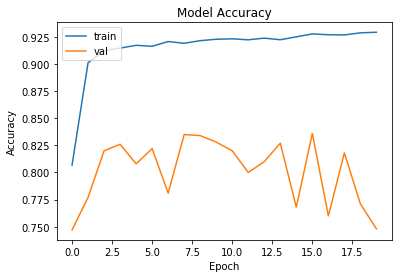

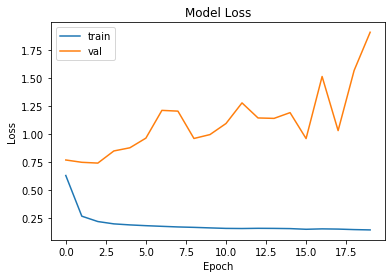

[0.84, 0.88, 0.86]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.67, 0.88, 0.76]
[1.0, 0.81, 0.89]
[0.95, 0.78, 0.86]
[0.97, 1.0, 0.99]
[0.96, 0.96, 0.96]
[0.98, 0.94, 0.96]
[1.0, 0.94, 0.97]
[0.98, 1.0, 0.99]
plotMat: [[0.84, 0.88, 0.86], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.67, 0.88, 0.76], [1.0, 0.81, 0.89], [0.95, 0.78, 0.86], [0.97, 1.0, 0.99], [0.96, 0.96, 0.96], [0.98, 0.94, 0.96], [1.0, 0.94, 0.97], [0.98, 1.0, 0.99]]
support: [1933, 54, 105, 0, 327, 21, 23, 315, 141, 154, 53, 740]
['weighted-avg', 'Stand in a lift-down', 'Stand in a lift-up', 'Bicycle', 'Stand on a solid surface', 'Stand up from a chair', 'Sit down on a chair', 'Sit on a chair', 'Stair down', 'Stair up', 'Run', 'Walk']


/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visib

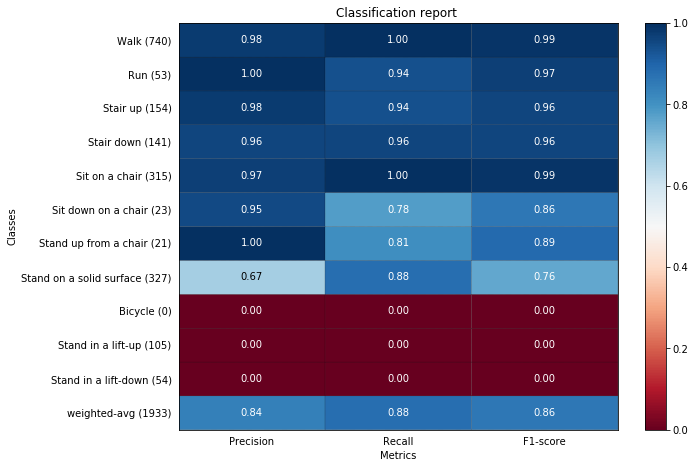

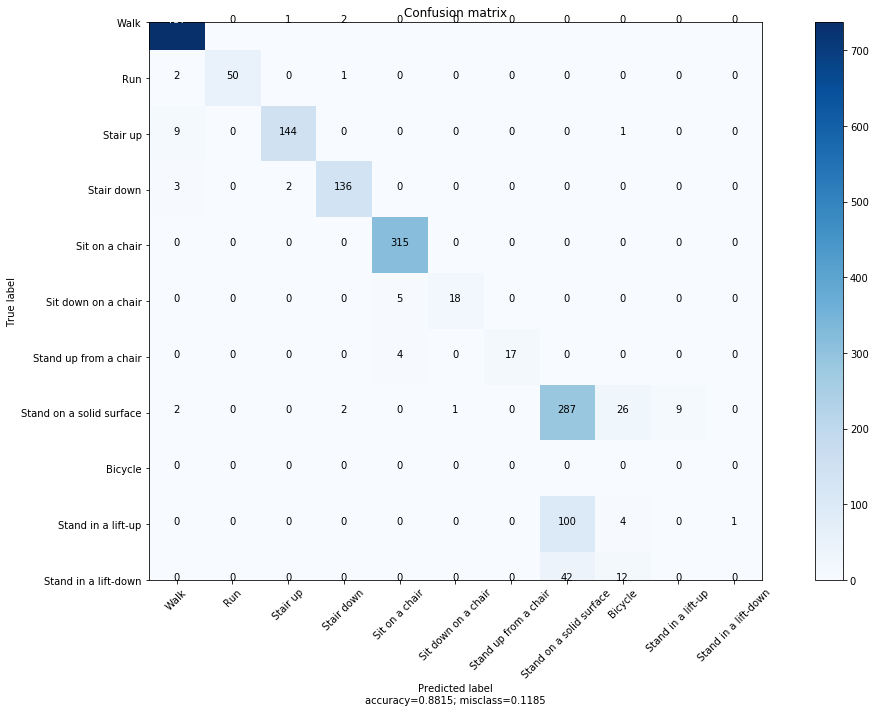

0.8815312984997413

In [25]:
evaluate_model(X_train, y_train_transform, X_test, y_test_transform, X_val, y_val_transform)

# CNN with PCA

In [10]:
df.head()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,gyro_ls_z,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act
0,-2.363223,0.545740,-2.728986,-0.345988,-0.292513,-0.410732,-1.001092,0.506787,-2.625044,0.206034,...,-0.002487,-0.009216,-0.170916,0.440473,0.582371,1.299102,0.515948,0.807379,0.145904,1
1,-2.363223,0.857305,-4.626821,0.171227,-0.193961,-0.131366,0.856330,0.884963,-3.015958,0.204905,...,-0.002681,-0.011330,-0.115550,-0.069824,0.972258,1.182668,0.492818,-1.335467,0.803628,1
2,-2.363223,3.489737,-4.896242,0.149194,-0.080462,0.075071,1.418281,2.374204,-3.315252,-0.053191,...,-0.002483,-0.019899,0.469532,-0.362730,1.967393,1.064525,0.000923,-3.269255,0.145904,1
3,-2.363223,3.238274,-4.896242,-0.169151,0.092115,0.150235,1.293956,1.493633,-2.669836,-0.175872,...,-0.002632,-0.021960,0.269018,-0.344042,2.123970,0.643767,0.169386,2.061728,-0.135978,1
4,-1.969328,-3.308910,2.316387,0.154133,0.225576,0.413839,-1.303203,-0.183316,2.024192,-0.405918,...,-0.002721,-0.018183,0.200933,-0.036644,2.148876,0.219165,0.090359,2.166257,0.051943,1


In [10]:
tmp = df[['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
       'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
       'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
       'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
       'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
       'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
       'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
       'gyro_lt_z', 'EMG_r', 'EMG_l']].values

In [11]:
tmp = tmp.reshape(-1, 100, 38)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tmp, y, test_size=0.3, random_state=128)

In [13]:
print(X_train.shape)

(14302, 100, 38)


In [14]:
X_train = X_train.reshape(-1, 38)
X_test = X_test.reshape(-1, 38)

In [15]:
X_train.shape

(1430200, 38)

# Test PCA

In [80]:
pca_test = PCA(n_components=0.9)
pca_test.fit(X_train)
t_X_train_transform = pca_test.transform(X_train)
print(t_X_train_transform.shape)

(1430200, 25)


In [81]:
pca_test.explained_variance_ratio_

array([0.10164133, 0.07919827, 0.07316934, 0.06607257, 0.0546119 ,
       0.04883065, 0.04656022, 0.03754683, 0.03536762, 0.03364396,
       0.03176872, 0.02990889, 0.02835279, 0.02761547, 0.02546689,
       0.0246751 , 0.02297324, 0.02104812, 0.02021119, 0.01837572,
       0.01684665, 0.01650056, 0.01593299, 0.01438202, 0.01379083])

In [16]:
from sklearn.decomposition import PCA

In [17]:
n_pca = 14
pca = PCA(n_components=n_pca)

[-2.36322294e+00  5.45740268e-01 -2.72898635e+00 -3.45988237e-01
 -2.92512705e-01 -4.10731828e-01 -1.00109203e+00  5.06786774e-01
 -2.62504366e+00  2.06033518e-01 -3.57687626e-01 -4.62491923e-01
 -3.51394712e-01 -1.01483164e+00  1.84355760e+00  2.08480854e-01
 -4.57376779e-02 -2.08699715e-01 -2.67732733e-01  2.86616232e-01
 -3.42572103e-01 -1.13700104e-01  3.06182726e-01 -3.51236087e-01
 -2.42490211e-01  4.88144458e-01  4.35378011e-01 -1.18203413e+00
  1.64827081e+00 -2.48715572e-03 -9.21640756e-03 -1.70916195e-01
  4.40472954e-01  5.82371387e-01  1.29910249e+00  5.15948290e-01
  8.07379121e-01  1.45903996e-01]
Eigen values 
 [4.02120157e+00 3.13204258e+00 2.57557467e+00 2.12978937e+00
 1.99929777e+00 1.92217724e+00 1.81959622e+00 1.45293121e+00
 1.32096463e+00 1.27364414e+00 1.20825172e+00 8.30246949e-05
 1.11882667e+00 1.08007244e+00 1.53800802e-01 1.87061488e-01
 2.00304510e-01 2.14386729e-01 2.29433782e-01 2.53084321e-01
 2.80703379e-01 1.01606375e+00 9.86970879e-01 9.21795664e-01


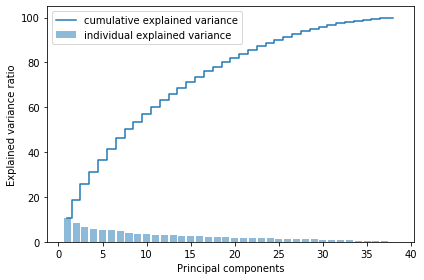

In [153]:
import numpy as np
label_name = "act"
features = list(df.columns)
features.remove(label_name)
tmp = df[features].values
print(tmp[0])
cov_mat = np.cov(tmp.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)
print("Eigen values \n", eigen_vals)
# eigen_vals = pca.explained_variance_ratio_
tot = sum(eigen_vals)
var_exp = [(i/tot)*100 for i in sorted(eigen_vals, reverse=True)]
cum_var_exp=np.cumsum(var_exp)

plt.bar(range(1, len(eigen_vals)+1), var_exp, alpha=0.5, align="center", label="individual explained variance")
plt.step(range(1, len(eigen_vals)+1), cum_var_exp, where='mid', label="cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/pca.svg", bbox_inches='tight')
plt.show()

In [18]:
df.describe()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,gyro_ls_z,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act
count,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,...,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06,2.043200e+06
mean,-3.371879e-17,-4.676673e-17,-4.345606e-17,4.743443e-18,-8.415786e-18,2.795988e-18,6.042674e-17,-4.685019e-17,2.214534e-17,6.391824e-18,...,3.640610e-20,-9.389513e-19,3.672343e-18,-1.206309e-16,8.165399e-18,6.551794e-18,-1.040497e-17,1.083202e-16,5.146844e-17,5.239722e+00
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.864811e+00
min,-2.363223e+00,-3.308910e+00,-4.896242e+00,-6.167561e+00,-2.914911e+00,-3.831466e+00,-2.670783e+00,-5.417052e+00,-3.635924e+00,-5.260903e+00,...,-1.162139e-02,-5.202869e-02,-6.398825e+00,-3.516047e+00,-6.027019e+00,-4.652013e+00,-1.273130e+01,-6.561921e+00,-5.961538e+00,1.000000e+00
25%,-6.790263e-02,-3.254866e-01,-6.735196e-02,1.186500e-02,1.137649e-02,-1.622360e-03,-1.730846e-01,-4.690180e-01,-3.640515e-01,-7.995216e-02,...,-7.958889e-04,-1.034635e-02,-4.058469e-01,-6.419065e-01,-7.030841e-02,-3.690578e-02,-1.278332e-01,-1.856471e-01,-1.829583e-01,1.000000e+00
50%,2.073439e-01,7.070044e-02,1.135828e-01,5.422236e-02,2.023806e-02,1.978590e-02,-3.197521e-02,7.823319e-02,1.072855e-01,2.209346e-02,...,-7.524636e-04,-7.333169e-03,3.259069e-02,-2.353468e-01,-2.086297e-02,1.106298e-02,-9.005438e-02,2.341107e-02,4.963032e-03,5.000000e+00
75%,4.232663e-01,3.005274e-01,2.601796e-01,9.012165e-02,7.609280e-02,8.859816e-02,2.900277e-01,5.123076e-01,4.315205e-01,7.158478e-02,...,-6.556682e-04,1.780806e-02,3.827422e-01,1.087307e+00,7.784478e-02,1.485639e-01,4.641187e-02,1.802047e-01,2.398646e-01,8.000000e+00
max,4.783481e+00,4.568553e+00,2.316387e+00,6.280375e+00,2.951180e+00,3.877272e+00,7.513802e+00,5.889413e+00,4.703457e+00,5.303962e+00,...,1.429404e+03,1.429052e+03,5.859284e+00,2.732520e+00,5.974488e+00,4.676274e+00,1.253230e+01,6.713272e+00,5.971464e+00,1.200000e+01


In [19]:
X_train.shape

(1430200, 38)

In [20]:
X_train_transform = pca.fit_transform(X_train)

In [21]:
X_train_transform = X_train_transform.reshape(-1, 100, n_pca)

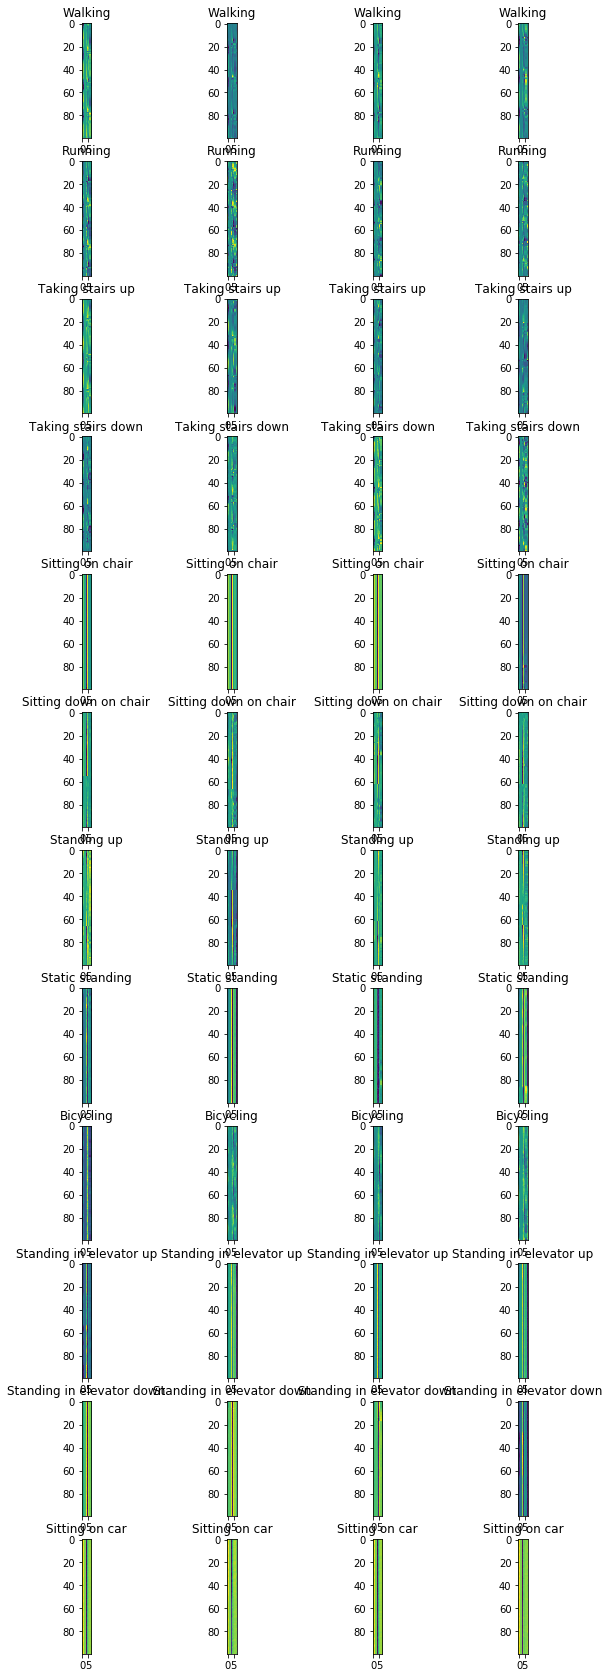

In [23]:
visualize_image(X_train_transform, y_train, (100, n_pca))

In [22]:
X_test_transform = pca.transform(X_test)

In [23]:
X_test_transform = X_test_transform.reshape(-1, 100, n_pca)

In [24]:
a = pca.explained_variance_ratio_
print(a)
a.sum()

[0.10164133 0.07919826 0.0731693  0.06607252 0.05461122 0.04883033
 0.04656007 0.03754488 0.03535186 0.03363929 0.03176799 0.02986443
 0.0283111  0.02755032]


0.6941128874950531

In [25]:
X_train_transform = X_train_transform.reshape(X_train_transform.shape[0], X_train_transform.shape[1], X_train_transform.shape[2], 1)
X_test_transform = X_test_transform.reshape(X_test_transform.shape[0], X_test_transform.shape[1], X_test_transform.shape[2], 1)
print(X_train.shape)
from keras.utils import to_categorical
y_train_transform = to_categorical(y_train)
y_test_transform = to_categorical(y_test)

(1430200, 38)


Using TensorFlow backend.


## Start 

In [26]:
file_name = [8, 10, 12]
df_train = df.loc[~df["file_name"].isin(["{}.csv".format(name) for name in file_name])].copy()
df_val = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[0:1]])].copy()
df_test = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[1:]])].copy()
_, y_train = make_data_set(df_train)
_, y_val = make_data_set(df_val)
_, y_test = make_data_set(df_test)
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1
all_columns = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
          'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
          'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
          'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
          'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
          'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
          'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
          'gyro_lt_z', 'EMG_r', 'EMG_l']
X_train = df_train[all_columns].values
X_train = X_train.reshape(-1, 100, 38)
X_val = df_val[all_columns].values
X_val = X_val.reshape(-1, 100, 38)
X_test = df_test[all_columns].values
X_test = X_test.reshape(-1, 100, 38)
print("Before pca: ")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
X_train = X_train.reshape(-1, 38)
X_val = X_val.reshape(-1, 38)
X_test = X_test.reshape(-1, 38)
from sklearn.decomposition import PCA

n_pca = 14
pca = PCA(n_components=n_pca)

X_train_transform = pca.fit_transform(X_train)
X_train_transform = X_train_transform.reshape(-1, 100, n_pca)
X_val_transform = pca.transform(X_val)
X_val_transform = X_val_transform.reshape(-1, 100, n_pca)
X_test_transform = pca.transform(X_test)
X_test_transform = X_test_transform.reshape(-1, 100, n_pca)

from keras.utils import to_categorical
import traceback

X_train_transform = X_train_transform.reshape(X_train_transform.shape[0], X_train_transform.shape[1],
                                              X_train_transform.shape[2], 1)
X_val_transform = X_val_transform.reshape(X_val_transform.shape[0], X_val_transform.shape[1],
                                              X_val_transform.shape[2], 1)
X_test_transform = X_test_transform.reshape(X_test_transform.shape[0], X_test_transform.shape[1],
                                            X_test_transform.shape[2], 1)
print("Start training")
print(X_train_transform.shape)
print(X_val_transform.shape)
print(X_test_transform.shape)
y_train_transform = to_categorical(y_train, num_classes=12)
y_val_transform = to_categorical(y_val, num_classes=12)
y_test_transform = to_categorical(y_test, num_classes=12)

(17499, 38, 100)
(17499,)
12
(1000, 38, 100)
(1000,)
10
(1933, 38, 100)
(1933,)
10
Before pca: 
(17499, 100, 38)
(1000, 100, 38)
(1933, 100, 38)
Start training
(17499, 100, 14, 1)
(1000, 100, 14, 1)
(1933, 100, 14, 1)


In [159]:
#conv_64|conv_112|conv_64|conv_128|conv_48|gru_48|dense_48
#1|60|272_conv_80|conv_32|conv_176|conv_160|conv_96|conv_48|pool|conv_208|pool|conv_96|pool|conv_192|pool|lstm_16|dense_288

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.layers import GRU, LSTM, Reshape, TimeDistributed, Embedding
from sklearn import metrics
import time

def evaluate_model_cnn_lstm(X_train, y_train, X_test, y_test, X_val, y_val):
    verbose, epochs, batch_size = 1, 20, 256
    #	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 12 # 100, 12, 3
    print(X_train.shape[1], X_train.shape[2])
    model = Sequential()
    model.add(Conv2D(80, kernel_size=(2, 2),activation='relu',input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3]))) #100, 12, 32
#     model.add(Conv2D(112, (3, 3), activation='relu'))  # 100, 12, 64
    model.add(Conv2D(32, kernel_size=(2, 2),activation='relu'))
    model.add(Conv2D(176, kernel_size=(2, 2),activation='relu'))
    model.add(Conv2D(160, kernel_size=(3, 3),activation='relu'))
    model.add(Conv2D(96, kernel_size=(3, 3),activation='relu'))
    model.add(Conv2D(48, kernel_size=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1))) 
#     model.add(Dropout(0.2))
    model.add(Conv2D(208, kernel_size=(2, 2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
#     model.add(Dropout(0.2))
    model.add(Conv2D(192, kernel_size=(2, 2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    
    model.add(Dropout(0.25))
#     model.add(Dropout(0.4))
    model.add(Reshape((-1, 192)))
    model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(288, activation='relu'))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dense(300, activation='relu'))
#     model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    # fit network
    start = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
    # evaluate model
    print("Training time: ", time.time()-start)
    _, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    print("Train: ", train_accuracy)
    
    _, val_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    print("Val: ", val_accuracy)
    
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print("Test: ", accuracy)
    y_pred = model.predict_classes(X_test, verbose=1)
    labels = np.argmax(y_test, axis=1)
    #draw
    cfs_matrix = metrics.confusion_matrix(labels, y_pred)
    print(cfs_matrix)
    
    cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
    clfReport = str(metrics.classification_report(labels, y_pred, target_names=cls))
    print(clfReport)
    draw_acc_history(history, save=True)
    draw_loss_history(history, save=True)
    plot_classification_report(clfReport, save=True)
    plot_confusion_matrix(cfs_matrix, target_names=cls, normalize    = False, save=True)
    return model


100 14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 99, 13, 80)        400       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 12, 32)        10272     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 11, 176)       22704     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 95, 9, 160)        253600    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 93, 7, 96)         138336    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 91, 5, 48)         41520     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 5, 48)         0         
___

/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


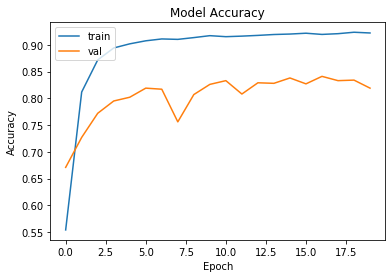

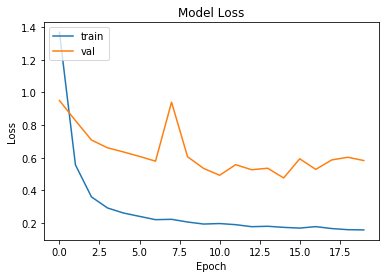

[0.85, 0.9, 0.87]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.68, 0.99, 0.81]
[0.9, 0.9, 0.9]
[0.95, 0.91, 0.93]
[1.0, 1.0, 1.0]
[0.94, 0.96, 0.95]
[1.0, 0.99, 0.99]
[0.96, 1.0, 0.98]
[0.99, 0.99, 0.99]
plotMat: [[0.85, 0.9, 0.87], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.68, 0.99, 0.81], [0.9, 0.9, 0.9], [0.95, 0.91, 0.93], [1.0, 1.0, 1.0], [0.94, 0.96, 0.95], [1.0, 0.99, 0.99], [0.96, 1.0, 0.98], [0.99, 0.99, 0.99]]
support: [1933, 54, 105, 0, 327, 21, 23, 315, 141, 154, 53, 740]
['weighted-avg', 'Stand in a lift-down', 'Stand in a lift-up', 'Bicycle', 'Stand on a solid surface', 'Stand up from a chair', 'Sit down on a chair', 'Sit on a chair', 'Stair down', 'Stair up', 'Run', 'Walk']


/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visib

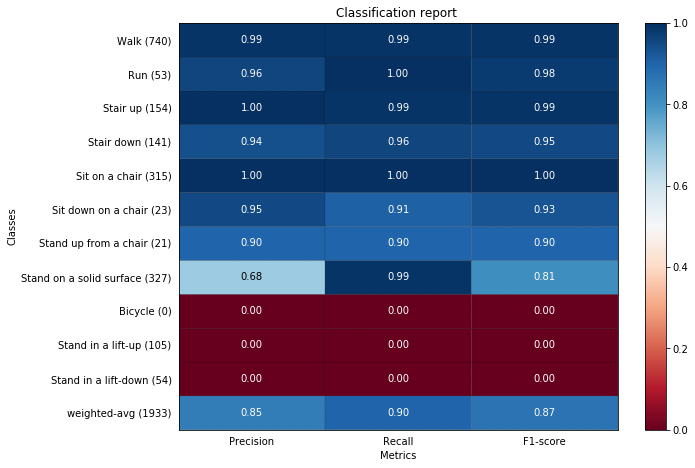

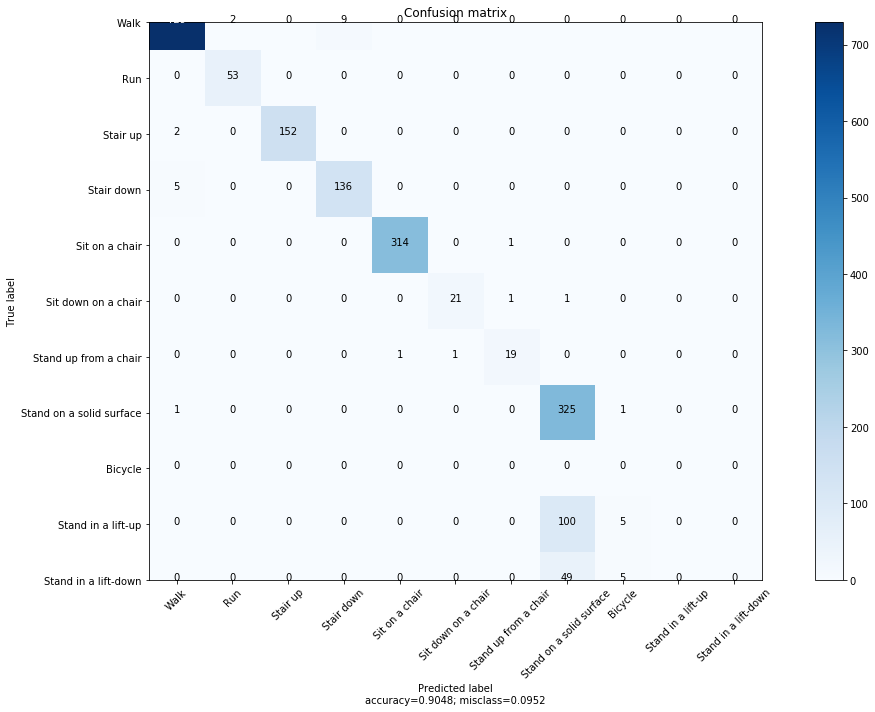

In [28]:
model1 =evaluate_model_cnn_lstm(X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform)

In [144]:
y_pred = model1.predict_classes(X_test_transform, verbose=1)
labels = y_test
cfs_matrix = metrics.confusion_matrix(labels, y_pred)
print(cfs_matrix)
np.save("model1_y_pred.npy", y_pred)
np.save("model1_y_true.npy", labels)
# np.save("cls_3d.npy", cfs_matrix)

1933/1933 [==============================] - 1s 453us/step
[[734   0   3   3   0   0   0   0   0   0   0]
 [  0  53   0   0   0   0   0   0   0   0   0]
 [  1   0 150   0   0   0   3   0   0   0   0]
 [ 11   0   1 129   0   0   0   0   0   0   0]
 [  0   0   0   0 312   0   3   0   0   0   0]
 [  0   0   0   0   0  19   4   0   0   0   0]
 [  0   0   0   0   1   0  20   0   0   0   0]
 [  0   0   0   1   0   0   1 324   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 105   0   0   0]
 [  0   0   0   0   0   0   0  54   0   0   0]]


In [142]:
cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
print(cls)

['Walk', 'Run', 'Stair up', 'Stair down', 'Sit on a chair', 'Sit down on a chair', 'Stand up from a chair', 'Stand on a solid surface', 'Bicycle', 'Stand in a lift-up', 'Stand in a lift-down']


# CNN Bester

In [122]:
#30|144_conv_48|conv_96|conv_224|conv_112|pool|conv_224|pool|conv_176|pool|lstm_16|dense_240

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.layers import GRU, LSTM, Reshape, TimeDistributed, Embedding
from sklearn import metrics
import time

def evaluate_model_cnn_lstm(X_train, y_train, X_test, y_test, X_val, y_val):
    verbose, epochs, batch_size = 1, 15, 144
    #	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 12 # 100, 12, 3
    print(X_train.shape[1], X_train.shape[2])
    model = Sequential()
    model.add(Conv2D(48, kernel_size=(2, 2),activation='relu',input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3]))) #100, 12, 32
#     model.add(Conv2D(112, (3, 3), activation='relu'))  # 100, 12, 64
    model.add(Conv2D(96, kernel_size=(2, 2),activation='relu'))
    model.add(Conv2D(224, kernel_size=(2, 2),activation='relu'))
    model.add(Conv2D(112, kernel_size=(2, 2),activation='relu'))
#     model.add(Conv2D(96, kernel_size=(3, 3),activation='relu'))
#     model.add(Conv2D(48, kernel_size=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1))) 
#     model.add(Dropout(0.2))
    model.add(Conv2D(224, kernel_size=(2, 2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
#     model.add(Dropout(0.2))
    model.add(Conv2D(176, kernel_size=(2, 2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    
    model.add(Dropout(0.25))
#     model.add(Dropout(0.4))
    model.add(Reshape((-1, 176)))
    model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(240, activation='relu'))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dense(300, activation='relu'))
#     model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    # fit network
    start = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
    # evaluate model
    print("Training time: ", time.time()-start)
    _, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    print("Train: ", train_accuracy)
    
    _, val_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    print("Val: ", val_accuracy)
    
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print("Test: ", accuracy)
    y_pred = model.predict_classes(X_test, verbose=1)
    labels = np.argmax(y_test, axis=1)
    #draw
    cfs_matrix = metrics.confusion_matrix(labels, y_pred)
    print(cfs_matrix)
    
    cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
    clfReport = str(metrics.classification_report(labels, y_pred, target_names=cls))
    print(clfReport)
    draw_acc_history(history, save=True)
    draw_loss_history(history, save=True)
    plot_classification_report(clfReport, save=True)
    plot_confusion_matrix(cfs_matrix, target_names=cls, normalize    = False, save=True)
    return model


In [30]:
file_name = [8, 14, 15]
df_train = df.loc[~df["file_name"].isin(["{}.csv".format(name) for name in file_name])].copy()
df_val = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[0:1]])].copy()
df_test = df.loc[df["file_name"].isin(["{}.csv".format(name) for name in file_name[1:]])].copy()
_, y_train = make_data_set(df_train)
_, y_val = make_data_set(df_val)
_, y_test = make_data_set(df_test)
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1
all_columns = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
          'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
          'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
          'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
          'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
          'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
          'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
          'gyro_lt_z', 'EMG_r', 'EMG_l']
X_train = df_train[all_columns].values
X_train = X_train.reshape(-1, 100, 38)
X_val = df_val[all_columns].values
X_val = X_val.reshape(-1, 100, 38)
X_test = df_test[all_columns].values
X_test = X_test.reshape(-1, 100, 38)
print("Before pca: ")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
X_train = X_train.reshape(-1, 38)
X_val = X_val.reshape(-1, 38)
X_test = X_test.reshape(-1, 38)
from sklearn.decomposition import PCA

n_pca = 14
pca = PCA(n_components=n_pca)

X_train_transform = pca.fit_transform(X_train)
X_train_transform = X_train_transform.reshape(-1, 100, n_pca)
X_val_transform = pca.transform(X_val)
X_val_transform = X_val_transform.reshape(-1, 100, n_pca)
X_test_transform = pca.transform(X_test)
X_test_transform = X_test_transform.reshape(-1, 100, n_pca)

from keras.utils import to_categorical
import traceback

X_train_transform = X_train_transform.reshape(X_train_transform.shape[0], X_train_transform.shape[1],
                                              X_train_transform.shape[2], 1)
X_val_transform = X_val_transform.reshape(X_val_transform.shape[0], X_val_transform.shape[1],
                                              X_val_transform.shape[2], 1)
X_test_transform = X_test_transform.reshape(X_test_transform.shape[0], X_test_transform.shape[1],
                                            X_test_transform.shape[2], 1)
print("Start training")
print(X_train_transform.shape)
print(X_val_transform.shape)
print(X_test_transform.shape)
y_train_transform = to_categorical(y_train, num_classes=12)
y_val_transform = to_categorical(y_val, num_classes=12)
y_test_transform = to_categorical(y_test, num_classes=12)

(17680, 38, 100)
(17680,)
12
(1000, 38, 100)
(1000,)
10
(1752, 38, 100)
(1752,)
10
Before pca: 
(17680, 100, 38)
(1000, 100, 38)
(1752, 100, 38)
Start training
(17680, 100, 14, 1)
(1000, 100, 14, 1)
(1752, 100, 14, 1)


100 14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 99, 13, 48)        240       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 98, 12, 96)        18528     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 97, 11, 224)       86240     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 10, 112)       100464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 10, 112)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 47, 9, 224)        100576    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 9, 224)        0         
___

/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


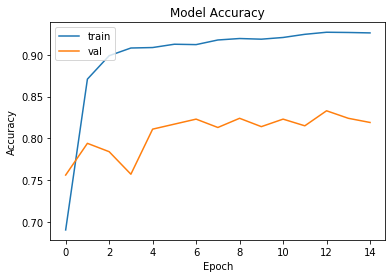

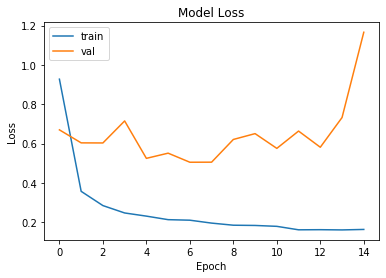

[0.9, 0.94, 0.91]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.62, 1.0, 0.76]
[0.94, 1.0, 0.97]
[1.0, 0.95, 0.98]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[0.98, 1.0, 0.99]
[1.0, 1.0, 1.0]
plotMat: [[0.9, 0.94, 0.91], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.62, 1.0, 0.76], [0.94, 1.0, 0.97], [1.0, 0.95, 0.98], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.98, 1.0, 0.99], [1.0, 1.0, 1.0]]
support: [1752, 41, 69, 176, 17, 22, 184, 130, 168, 51, 894]
['weighted-avg', 'Stand in a lift-down', 'Stand in a lift-up', 'Stand on a solid surface', 'Stand up from a chair', 'Sit down on a chair', 'Sit on a chair', 'Stair down', 'Stair up', 'Run', 'Walk']


/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ntkhang/Desktop/PythonProject/DLFW/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visib

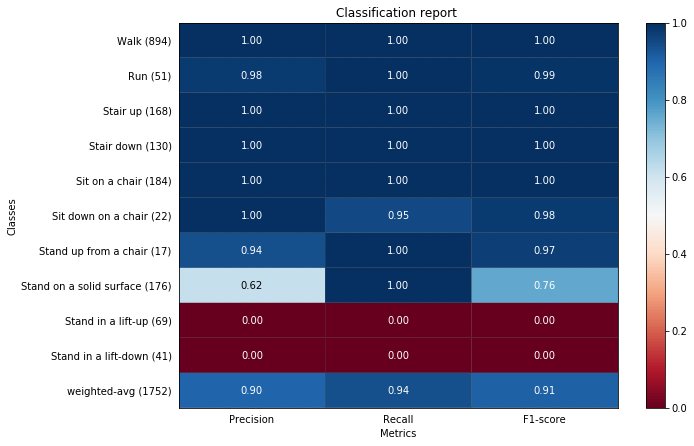

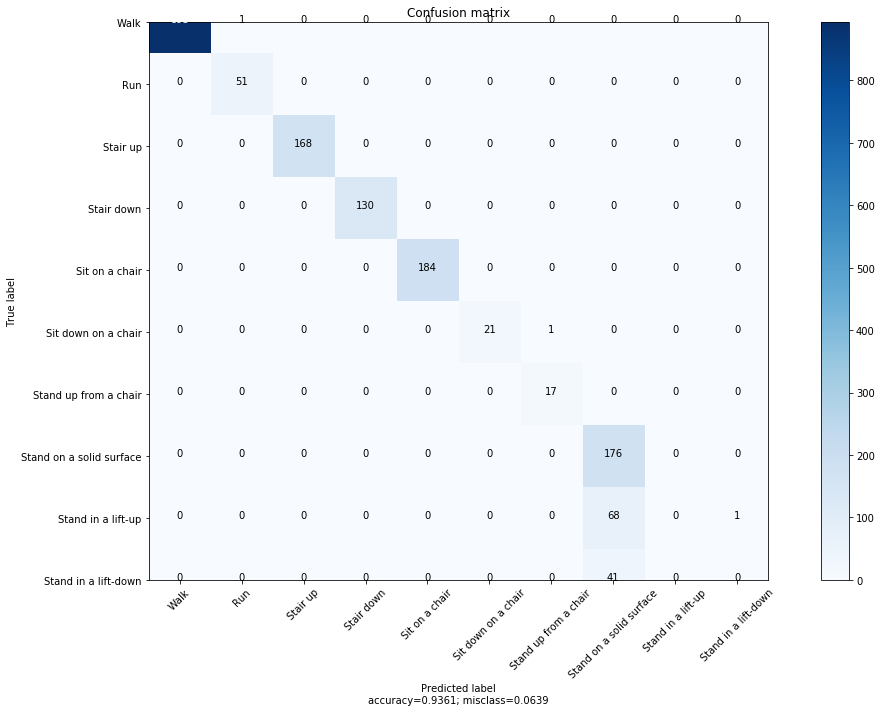

In [31]:
model = evaluate_model_cnn_lstm(X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform)

In [138]:
y_pred = model.predict_classes(X_test_transform, verbose=1)
labels = y_test
cfs_matrix = metrics.confusion_matrix(labels, y_pred)
print(cfs_matrix)
np.save("cls_3d_better.npy", cfs_matrix)

1752/1752 [==============================] - 2s 903us/step
[[893   1   0   0   0   0   0   0   0   0]
 [  0  51   0   0   0   0   0   0   0   0]
 [  1   0 167   0   0   0   0   0   0   0]
 [  1   0   0 129   0   0   0   0   0   0]
 [  0   0   0   0 184   0   0   0   0   0]
 [  0   0   0   0   0  22   0   0   0   0]
 [  0   0   1   0   0   0  15   1   0   0]
 [  0   0   0   0   0   0   0 175   0   1]
 [  0   0   0   0   0   0   0  69   0   0]
 [  0   0   0   0   0   0   0  41   0   0]]


In [139]:
cls = [labels_map[int(idx)] for idx in np.unique(np.concatenate([y_pred, labels]))]
print(cls)

['Walk', 'Run', 'Stair up', 'Stair down', 'Sit on a chair', 'Sit down on a chair', 'Stand up from a chair', 'Stand on a solid surface', 'Stand in a lift-up', 'Stand in a lift-down']
